# A Song of Vice and Higher: Characterizing Presidential Nominees through Game of Thrones

---

## Table of Contents

**<a href=#get_data>Get Data</a>**

**<a href=#attribution>Comment Attribution</a>**

**<a href=#person_sentiment>Sentiment by Person</a>**

**<a href=#clusters>Cluster Analysis</a>**

**<a href=#embeddings>Word Embeddings</a>**

**<a href=#clusters2>Cluster Analysis, Revisited</a>**

**<a href=#embeddings2>Word Embeddings, Revisited: Direct Similarities</a>**


### Import Necessary Libraries

In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%reload_ext autoreload

In [26]:
import os             # file system stuff
import json           # digest json
import pandas as pd   # Dataframes
import numpy as np    # arrays and matrix ops
import string         # string manipulation
import time           # timing

import psycopg2 as psql # PostgreSQL
from itertools import chain # Chain

# Plotting
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import gensim         # Word embeddings

# Custom Libs
import helper     # Custom helper functions
from helper import attribute_comment 
from helper import create_person_mat
from helper import add_similarity_score
from helper import person_dict
from helper import domain_dict
from helper import no_spaces_dict


### Connect to the database <a name="get_data"/>

In [27]:
# Define path to secret

secret_path_aws = os.path.join(os.environ['HOME'], 'mia', '.secret', 
                           'aws_ps_flatiron.json')
# secret_path_aws = os.path.join(os.environ['HOME'], '.secret', 
#                            'aws_ps_flatiron.json')
secret_path_aws

'/Users/tjjj/mia/.secret/aws_ps_flatiron.json'

In [28]:
aws_keys = helper.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

# Setup PSQL connection
conn = psql.connect(
    database=db,
    user=user,
    password=ps,
    host=host,
    port='5432'
)

In [29]:
get_database = """
    SELECT * FROM comms_sntmnt_190614;
"""
# Instantiate cursor
cur = conn.cursor()
cur.execute(get_database)
comments = pd.DataFrame(cur.fetchall())
comments.columns = [col.name for col in cur.description]
comments.drop('index', axis=1, inplace=True) #superfluous column
comments.drop(['compound', 'neu'], axis=1, inplace=True) 
#compound and neutral are correlated with other sentiment columns

In [30]:
comments.head()

domain                                            comment  sub_num_comments  \
0   dems  2016, when the dnc pulled the same bullshit th...               710   
1   dems  2016: who the hell is beto?\n\n2019: how could...               759   
2   dems  >2017 house approval of a $700 billion defense...               105   
3   dems                                               2018               850   
4   dems                                              2018?               508   

   sub_upvote_ratio    neg    pos  
0              0.97  0.236  0.069  
1              0.96  0.228  0.175  
2              0.43  0.088  0.383  
3              0.93  0.000  0.000  
4              0.96  0.000  0.000

In [31]:
comments.shape

(324629, 6)

## Attribute Comment to Person <a name='attribution' />

In order to attribute people to `comment`s, we can perform count vectorization. We will need to create a vocabulary.

In [32]:
# Vocabulary will be list of all the search terms we used 
# to pull reddit submissions
vocab = list(chain(*helper.person_dict.values()))

vocab[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Next, set up a vectorizer, and then vectorize on this `vocab`.

In [33]:
vectorizer = CountVectorizer(vocabulary=vocab)

vectorized_words = vectorizer.transform(comments['comment'])

In [34]:
vectorized_words.shape

(324629, 114)

This gets us an $axn$ matrix, where:
- $a$ is the number of _comments_
- $n$ is the number of _vocab words (search terms)_.

Let's take a look at the vectorized words. Here's one row.

In [35]:
vectorized_words.todense()[5, :]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]])

The columns show the count of vocab words in the comment (row).

In [36]:
# Check
vectorizer.vocabulary[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'danny',
 'danaerys']

Now we want to set up a $nxm$ matrix, where:
- $n$ will be number of search terms (e.g. 'dany', daenerys' for **daenerys**) 
- $m$ is the actual number of persons (e.g. **daenerys** herself). 

Let's start with a matrix of `0`s.

In [37]:
person_mat = np.zeros((len(person_dict), len(vocab))).T

person_mat.shape

(114, 67)

Now, let's assign column IDs in the matrix for each _person_.

In [38]:
person_ids = {}

for i, name in enumerate(person_dict.keys()):
    person_ids[name] = i
    
person_ids               

{'bran': 0,
 'jon': 1,
 'dany': 2,
 'davos': 3,
 'doran': 4,
 'cersei': 5,
 'tyrion': 6,
 'sansa': 7,
 'arya': 8,
 'stannis': 9,
 'varys': 10,
 'jamie': 11,
 'brienne': 12,
 'samwell': 13,
 'jorah': 14,
 'theon': 15,
 'hound': 16,
 'littlefinger': 17,
 'joffrey': 18,
 'mountain': 19,
 'robb': 20,
 'dragons': 21,
 'melisandre': 22,
 'bronn': 23,
 'gilly': 24,
 'ramsey': 25,
 'missandei': 26,
 'gendry': 27,
 'grey worm': 28,
 'ned': 29,
 'catelyn': 30,
 'tormund': 31,
 'robert': 32,
 'tommen': 33,
 'viserys': 34,
 'margaery': 35,
 'euron': 36,
 'oberyn': 37,
 'night_king': 38,
 'lyanna': 39,
 'jaqen': 40,
 'hodor': 41,
 'ygritte': 42,
 'mance': 43,
 'harris': 44,
 'biden': 45,
 'buttigieg': 46,
 'gillibrand': 47,
 'hickenlooper': 48,
 'klobuchar': 49,
 'warren': 50,
 'booker': 51,
 'inslee': 52,
 'castro': 53,
 'gabbard': 54,
 'sanders': 55,
 'de blasio': 56,
 'bullock': 57,
 'gravel': 58,
 'messam': 59,
 "o'rourke": 60,
 'bennet': 61,
 'delaney': 62,
 'moulton': 63,
 'swalwell': 64,
 'w

...and assign row ids for each _search term_.

In [39]:
vocab_ids = {}

for i, word in enumerate(vocab):
    vocab_ids[word] = i
    
vocab_ids                

{'bran': 0,
 'brandon stark': 1,
 'jon': 2,
 'jon snow': 3,
 'khaleesi': 4,
 'dany': 5,
 'daenerys': 6,
 'danyris': 7,
 'danny': 8,
 'danaerys': 9,
 'daenarys': 10,
 'davos': 11,
 'doran': 12,
 'cersei': 13,
 'cercei': 14,
 'tyrion': 15,
 'tirion': 16,
 'sansa': 17,
 'arya': 18,
 'stannis': 19,
 'varys': 20,
 'varis': 21,
 'jamie': 22,
 'jaime': 23,
 'brienne': 24,
 'brianne': 25,
 'samwell': 26,
 'jorah': 27,
 'theon': 28,
 'hound': 29,
 'sandor': 30,
 'littlefinger': 31,
 'baelish': 32,
 'joffrey': 33,
 'joff': 34,
 'mountain': 35,
 'gregor': 36,
 'robb': 37,
 'drogo': 38,
 'melisandre': 39,
 'bronn': 40,
 'gilly': 41,
 'ramsey': 42,
 'ramsay': 43,
 'missandei': 44,
 'gendry': 45,
 'grey worm': 46,
 'greyworm': 47,
 'gray worm': 48,
 'grayworm': 49,
 'ned': 50,
 'eddard': 51,
 'catelyn': 52,
 'torumund': 53,
 'tormund': 54,
 'giantsbane': 55,
 'robert': 56,
 'tommen': 57,
 'viserys': 58,
 'margaery': 59,
 'euron': 60,
 'oberon': 61,
 'oberyn': 62,
 'viper': 63,
 'red viper': 64,
 'ni

Now let's use `person_dict` to fill a 1 where each _search term_ matches it's _person_. 

In [40]:
for name, words in person_dict.items():
    person_id = person_ids[name]
    for word in words:
        vocab_id = vocab_ids[word]
        person_mat[vocab_id, person_id] = 1 

In [41]:
person_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Now we can use matrix multplication to get an $axm$ matrix where:
- $a$: number of _comments_
- $m$: number of _persons_

In [42]:
mentions = vectorized_words @ person_mat 

mentions.shape

(324629, 67)

In [43]:
mentions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Get list of _persons_.

In [44]:
persons = list(person_dict.keys())

Create a dataframe from the matrix, with _persons_ as column headers.

In [45]:
mentions_df = pd.DataFrame(mentions, columns=persons, index=comments.index) 

mentions_df.head()

bran  jon  dany  davos  doran  cersei  tyrion  sansa  arya  stannis  ...  \
0   0.0  0.0   0.0    0.0    0.0     0.0     0.0    0.0   0.0      0.0  ...   
1   0.0  0.0   0.0    0.0    0.0     0.0     0.0    0.0   0.0      0.0  ...   
2   0.0  0.0   0.0    0.0    0.0     0.0     0.0    0.0   0.0      0.0  ...   
3   0.0  0.0   0.0    0.0    0.0     0.0     0.0    0.0   0.0      0.0  ...   
4   0.0  0.0   0.0    0.0    0.0     0.0     0.0    0.0   0.0      0.0  ...   

   bullock  gravel  messam  o'rourke  bennet  delaney  moulton  swalwell  \
0      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
1      0.0     0.0     0.0       2.0     0.0      0.0      0.0       0.0   
2      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
3      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
4      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   

   williamson  yang  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  

[5 rows x 67 columns]

Create a `comment_length` feature, in case we want to use it as some sort of weighting metric, i.e. the longer the comment, the more weight it carries.

In [46]:
comments['comment_length'] = comments['comment'].str.len()

comments.head()

domain                                            comment  sub_num_comments  \
0   dems  2016, when the dnc pulled the same bullshit th...               710   
1   dems  2016: who the hell is beto?\n\n2019: how could...               759   
2   dems  >2017 house approval of a $700 billion defense...               105   
3   dems                                               2018               850   
4   dems                                              2018?               508   

   sub_upvote_ratio    neg    pos  comment_length  
0              0.97  0.236  0.069             276  
1              0.96  0.228  0.175              80  
2              0.43  0.088  0.383             170  
3              0.93  0.000  0.000               4  
4              0.96  0.000  0.000               5

The `comment`s have served their purpose, so we can drop them. 

In [47]:
com_use = comments.drop(['comment'],axis=1).copy()

com_use.head()

domain  sub_num_comments  sub_upvote_ratio    neg    pos  comment_length
0   dems               710              0.97  0.236  0.069             276
1   dems               759              0.96  0.228  0.175              80
2   dems               105              0.43  0.088  0.383             170
3   dems               850              0.93  0.000  0.000               4
4   dems               508              0.96  0.000  0.000               5

Create a master table that has the sentiment analysis **and** the mentions counts.

In [48]:
snm = com_use.join(mentions_df)

snm.head()

domain  sub_num_comments  sub_upvote_ratio    neg    pos  comment_length  \
0   dems               710              0.97  0.236  0.069             276   
1   dems               759              0.96  0.228  0.175              80   
2   dems               105              0.43  0.088  0.383             170   
3   dems               850              0.93  0.000  0.000               4   
4   dems               508              0.96  0.000  0.000               5   

   bran  jon  dany  davos  ...  bullock  gravel  messam  o'rourke  bennet  \
0   0.0  0.0   0.0    0.0  ...      0.0     0.0     0.0       0.0     0.0   
1   0.0  0.0   0.0    0.0  ...      0.0     0.0     0.0       2.0     0.0   
2   0.0  0.0   0.0    0.0  ...      0.0     0.0     0.0       0.0     0.0   
3   0.0  0.0   0.0    0.0  ...      0.0     0.0     0.0       0.0     0.0   
4   0.0  0.0   0.0    0.0  ...      0.0     0.0     0.0       0.0     0.0   

   delaney  moulton  swalwell  williamson  yang  
0      0.0      0.0       0.0         0.0   0.0  
1      0.0      0.0       0.0         0.0   0.0  
2      0.0      0.0       0.0         0.0   0.0  
3      0.0      0.0       0.0         0.0   0.0  
4      0.0      0.0       0.0         0.0   0.0  

[5 rows x 73 columns]

_**Version of table with `comment` column preserved**_


In [49]:
comm_snm = comments.join(mentions_df)

comm_snm.head()

domain                                            comment  sub_num_comments  \
0   dems  2016, when the dnc pulled the same bullshit th...               710   
1   dems  2016: who the hell is beto?\n\n2019: how could...               759   
2   dems  >2017 house approval of a $700 billion defense...               105   
3   dems                                               2018               850   
4   dems                                              2018?               508   

   sub_upvote_ratio    neg    pos  comment_length  bran  jon  dany  ...  \
0              0.97  0.236  0.069             276   0.0  0.0   0.0  ...   
1              0.96  0.228  0.175              80   0.0  0.0   0.0  ...   
2              0.43  0.088  0.383             170   0.0  0.0   0.0  ...   
3              0.93  0.000  0.000               4   0.0  0.0   0.0  ...   
4              0.96  0.000  0.000               5   0.0  0.0   0.0  ...   

   bullock  gravel  messam  o'rourke  bennet  delaney  moulton  swalwell  \
0      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
1      0.0     0.0     0.0       2.0     0.0      0.0      0.0       0.0   
2      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
3      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   
4      0.0     0.0     0.0       0.0     0.0      0.0      0.0       0.0   

   williamson  yang  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  

[5 rows x 74 columns]

---

### <font color='red'> Digression: Saving out dataframe to-date as a tab-delimited file.

<font color='red'> 2019.06.15 - I commented out these cells; might want to keep them for a couple more days, but don't want to have to keep manually skipping.

**<a href=#bookmark>Click here to skip this section</a>**

#### Write out to tsv

comm_snm.to_csv('comm_snm_190614.tsv', sep='\t')

##### Test reading back in

csnm_test = pd.read_csv('comm_snm_190614.tsv', sep='\t')

csnm_test.info()

csnm_test.head()

csnm_test.shape

comm_snm.shape

We _gained_ a few rows? and a weird index column. Immaterial for now, for think is easily fixable.

Check file size.

file_path_nm = "comm_snm_190614.tsv"
filesize = os.path.getsize(file_path_nm)/1000000

print("file_path_nm is roughly {:,.0f}MB.".format(filesize))

### <font color='red'>End Digression.<a name='bookmark' /></font>

---

## Get aggregate sentiment <a name="person_sentiment" />

We want a table that has `person` on the row, and a column for each `sentiment` metric. We can use matrix multiplication again to achieve that.

In [50]:
mentions.shape

(324629, 67)

In [51]:
# Transpose the mentions matrix
men_t = mentions.T


In [52]:
men_t.shape

(67, 324629)

Isolate just the metrics columns.

In [53]:
# Get the positive sentiment column as an array
features = np.array(snm[['pos','neg','comment_length', 'sub_num_comments', 'sub_upvote_ratio']])

In [54]:
features.shape

(324629, 5)

Compute target matrix of aggregated sentiment.

In [55]:
snm_agg = men_t @ features 

In [56]:
snm_agg.shape

(67, 5)

This gives us a matrix of rows of **persons** by [ **neg**, **pos**, **comment length** ]. But recall this is matrix multiplication, so it gives us the sumproduct. So we need to take the weighted average.

Create an $mx1$ matrix that represents a column of total comment 'hits' for each `person`.

In [57]:
# Get total comments 'hits' by person
men_t_agg = men_t.sum(axis=1)

In [58]:
men_t_agg.shape

(67,)

In [59]:
num_persons = len(persons)

In [60]:
# We need this as an nx1 array
men_t_agg = np.reshape(men_t_agg,(num_persons,1))

In [61]:
men_t_agg.shape

(67, 1)

Now divide the original matrix by 'hits' to get average 'scores'.

In [62]:
snm_avg = np.divide(snm_agg, men_t_agg)

/Users/tjjj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [63]:
snm_avg[0]

array([9.58706816e-02, 9.64069795e-02, 8.31949230e+02, 6.70082750e+02,
       8.27109691e-01])

This looks right. Now make `persons_df`

In [64]:
persons_df = pd.DataFrame(snm_avg, columns=['neg','pos','comment_length','sub_num_comments', 'sub_upvote_ratio'])

In [65]:
# Add the person's name back in
persons_df['person'] = persons

In [66]:
# Add domain back in
persons_df['domain'] = persons_df['person'].map(domain_dict)

In [67]:
persons_df = persons_df[['person', 'domain', 'neg', 'pos', 'comment_length','sub_num_comments', 'sub_upvote_ratio']]

In [68]:
persons_df.shape

(67, 7)

In [69]:
persons_df.tail(30)

person domain       neg       pos  comment_length  sub_num_comments  \
37        oberyn    got  0.118462  0.124522      534.238994        479.792453   
38    night_king    got  0.096079  0.121316      371.236842        903.605263   
39        lyanna    got       NaN       NaN             NaN               NaN   
40         jaqen    got  0.081677  0.087890      668.445122        419.310976   
41         hodor    got  0.058301  0.060560      917.197970        932.293147   
42       ygritte    got  0.131634  0.102654      500.151220        613.790244   
43         mance    got  0.095994  0.117767      493.245283        609.440252   
44        harris   dems  0.121952  0.073905      601.044709        660.970194   
45         biden   dems  0.112405  0.086870      550.885796        732.629943   
46     buttigieg   dems  0.121666  0.065769      646.673913       1027.962560   
47    gillibrand   dems  0.107993  0.062662      727.267606        521.179577   
48  hickenlooper   dems  0.104155  0.069456      423.922280        539.564767   
49     klobuchar   dems  0.099053  0.058791      570.262032        845.090909   
50        warren   dems  0.128463  0.066028      579.511811       1126.075730   
51        booker   dems  0.105749  0.063276      611.475483        668.585438   
52        inslee   dems  0.139332  0.049005      606.786925        466.641646   
53        castro   dems  0.109613  0.079823      598.161585        731.137195   
54       gabbard   dems  0.107591  0.092146     1330.751905        688.318571   
55       sanders   dems  0.121713  0.078032      617.271328        856.240578   
56     de blasio   dems  0.100213  0.071809      365.375887        283.730496   
57       bullock   dems  0.135164  0.064812      352.851562        533.695312   
58        gravel   dems  0.106651  0.117227      342.558140        477.808140   
59        messam   dems  0.096429  0.035143      449.785714        546.214286   
60      o'rourke   dems  0.123223  0.067286      729.096105        707.070258   
61        bennet   dems  0.117696  0.052884      682.333333        386.449275   
62       delaney   dems  0.100648  0.073381      592.190476        556.676190   
63       moulton   dems  0.121841  0.063362      419.956522        505.579710   
64      swalwell   dems  0.133085  0.066930      554.845070        728.112676   
65    williamson   dems  0.085211  0.072123      443.578947        494.824561   
66          yang   dems  0.127172  0.059265      641.174575        984.137668   

    sub_upvote_ratio  
37          0.831691  
38          0.835658  
39               NaN  
40          0.841022  
41          0.867453  
42          0.846740  
43          0.839277  
44          0.783690  
45          0.743179  
46          0.838075  
47          0.806185  
48          0.846796  
49          0.786854  
50          0.833044  
51          0.796424  
52          0.831170  
53          0.798994  
54          0.740875  
55          0.775649  
56          0.554693  
57          0.846810  
58          0.658266  
59          0.778095  
60          0.823532  
61          0.782802  
62          0.829984  
63          0.740193  
64          0.814343  
65          0.690614  
66          0.839453

In [70]:
persons_df.sort_values(by=['comment_length'], axis=0, ascending=False)

person domain       neg       pos  comment_length  sub_num_comments  \
54       gabbard   dems  0.107591  0.092146     1330.751905        688.318571   
36         euron    got  0.097175  0.139224      958.506540       1093.149752   
41         hodor    got  0.058301  0.060560      917.197970        932.293147   
20          robb    got  0.098480  0.131667      902.553476        748.147059   
12       brienne    got  0.117134  0.113103      898.926866        612.544279   
26     missandei    got  0.105467  0.144538      891.237405       1195.407177   
2           dany    got  0.101242  0.136775      887.895739       1012.821503   
5         cersei    got  0.104796  0.141244      865.036902        931.988191   
21       dragons    got  0.103937  0.132336      863.264463        929.385675   
7          sansa    got  0.106343  0.116680      836.954370        752.102963   
0           bran    got  0.095871  0.096407      831.949230        670.082750   
22    melisandre    got  0.099591  0.121415      825.482972        536.560372   
11         jamie    got  0.112045  0.135326      822.123420        896.681269   
34       viserys    got  0.105871  0.125583      821.710425        856.579151   
6         tyrion    got  0.108242  0.118347      803.106100        811.753004   
10         varys    got  0.101486  0.127533      800.279455       1004.412374   
1            jon    got  0.105712  0.123610      797.009912        840.442815   
32        robert    got  0.099547  0.120995      792.268309        626.171105   
17  littlefinger    got  0.109987  0.113178      765.276119        667.201493   
15         theon    got  0.114545  0.121049      755.313199        585.885906   
8           arya    got  0.098847  0.130279      738.826286        748.072647   
60      o'rourke   dems  0.123223  0.067286      729.096105        707.070258   
47    gillibrand   dems  0.107993  0.062662      727.267606        521.179577   
31       tormund    got  0.126600  0.091105      726.226371        569.534422   
28     grey worm    got  0.096666  0.149123      717.217759        805.680761   
14         jorah    got  0.112005  0.130566      715.514748       1555.557088   
30       catelyn    got  0.113957  0.111492      698.189189        466.764865   
23         bronn    got  0.111327  0.111018      694.823454        550.132569   
3          davos    got  0.124050  0.092575      692.760499        529.203178   
61        bennet   dems  0.117696  0.052884      682.333333        386.449275   
..           ...    ...       ...       ...             ...               ...   
16         hound    got  0.109374  0.126871      628.302475        641.535644   
55       sanders   dems  0.121713  0.078032      617.271328        856.240578   
33        tommen    got  0.098114  0.119882      614.760714        648.917857   
51        booker   dems  0.105749  0.063276      611.475483        668.585438   
52        inslee   dems  0.139332  0.049005      606.786925        466.641646   
44        harris   dems  0.121952  0.073905      601.044709        660.970194   
53        castro   dems  0.109613  0.079823      598.161585        731.137195   
62       delaney   dems  0.100648  0.073381      592.190476        556.676190   
13       samwell    got  0.120397  0.086103      591.793651        486.611111   
50        warren   dems  0.128463  0.066028      579.511811       1126.075730   
49     klobuchar   dems  0.099053  0.058791      570.262032        845.090909   
19      mountain    got  0.097830  0.126379      560.317915        720.126384   
64      swalwell   dems  0.133085  0.066930      554.845070        728.112676   
45         biden   dems  0.112405  0.086870      550.885796        732.629943   
37        oberyn    got  0.118462  0.124522      534.238994        479.792453   
4          doran    got  0.086200  0.117733      532.200000        453.000000   
18       joffrey    got  0.109822  0.140544      520.881590        909.345499   
24         gilly    got  0.110157  0.0783

Let's get rid of nulls.

In [71]:
persons_df = persons_df.dropna(axis=0)

In [72]:
persons_df.shape

(66, 7)

---

## Cluster Analysis <a name='clusters'/>

### Data Setup

In [73]:
# Create a person-indexed df
persons_cluster = persons_df.set_index(['person']).drop(['domain'], axis=1)

In [74]:
persons_cluster.tail()

neg       pos  comment_length  sub_num_comments  \
person                                                             
delaney     0.100648  0.073381      592.190476        556.676190   
moulton     0.121841  0.063362      419.956522        505.579710   
swalwell    0.133085  0.066930      554.845070        728.112676   
williamson  0.085211  0.072123      443.578947        494.824561   
yang        0.127172  0.059265      641.174575        984.137668   

            sub_upvote_ratio  
person                        
delaney             0.829984  
moulton             0.740193  
swalwell            0.814343  
williamson          0.690614  
yang                0.839453

In [75]:
persons_cluster.shape

(66, 5)

Drop any nulls.

In [76]:
persons_cluster = persons_cluster.dropna(axis=0)

persons_cluster.shape

(66, 5)

In [77]:
persons_cluster.head()

neg       pos  comment_length  sub_num_comments  sub_upvote_ratio
person                                                                        
bran    0.095871  0.096407      831.949230        670.082750          0.827110
jon     0.105712  0.123610      797.009912        840.442815          0.824976
dany    0.101242  0.136775      887.895739       1012.821503          0.815247
davos   0.124050  0.092575      692.760499        529.203178          0.834927
doran   0.086200  0.117733      532.200000        453.000000          0.821367

Scale the data.

In [78]:
persons_cluster.dropna(axis=0).shape

(66, 5)

In [79]:
ss = StandardScaler()

ss.fit(persons_cluster)

scaled_X = ss.transform(persons_cluster.dropna(axis=0))

scaled_df = pd.DataFrame(scaled_X, columns=persons_cluster.columns
                         , index=persons_cluster.index)

scaled_df.head()

neg       pos  comment_length  sub_num_comments  sub_upvote_ratio
person                                                                        
bran   -0.916536 -0.149890        0.948253         -0.173193          0.287603
jon    -0.215131  0.776966        0.746595          0.600592          0.244054
dany   -0.533699  1.225546        1.271157          1.383545          0.045522
davos   1.091774 -0.280437        0.144904         -0.813075          0.447140
doran  -1.605757  0.576743       -0.781796         -1.159194          0.170401

### Find optimal K

**Elbow Method**

In [80]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    cluster_variation.append(kmeans.inertia_)

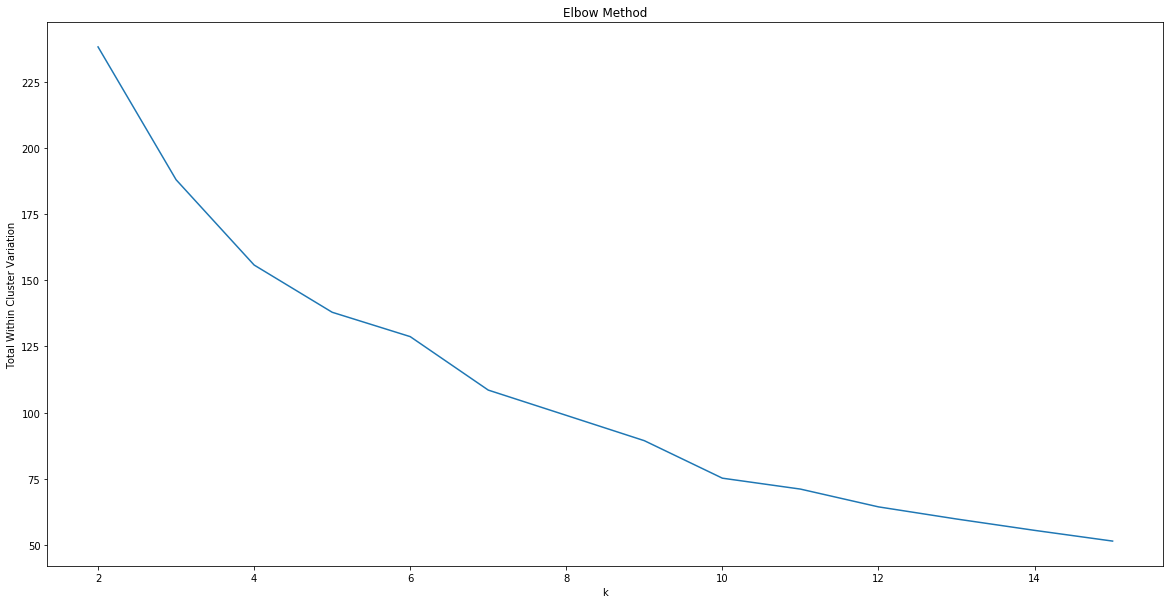

In [81]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Right now we would say k = 4.

### Silhouette Method

In [82]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [83]:
#Check 
silhouette_score

[0.28323767017617635,
 0.3000191760396893,
 0.23671211234473763,
 0.23394657119272086,
 0.2365476105885892,
 0.24244119137725903,
 0.2387354478215547,
 0.20787834505987515,
 0.22895145207409853,
 0.21873148593131628,
 0.23960878097817195,
 0.2208507959651452,
 0.2046669573816621,
 0.23771490642677445]

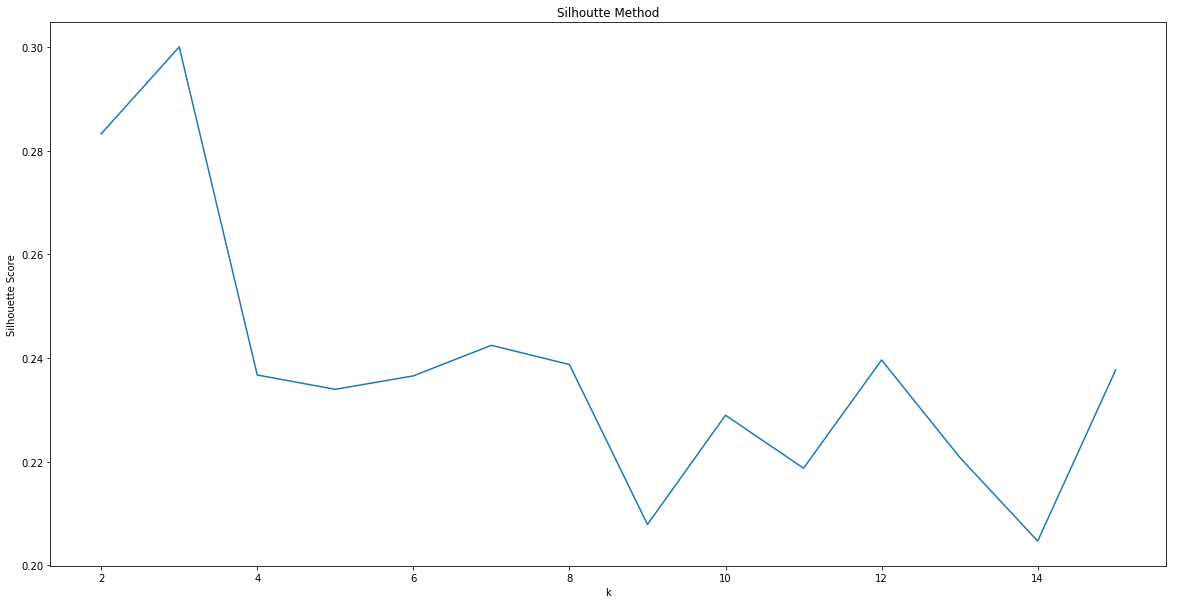

In [84]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


For silhouette scores, we are looking for the highest score; here it's at where k=3. Let's remember this for later. For now let's do some PCA.

### Principal Components Analysis

This will help us visualize the clusters.

In [85]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

In [86]:
persons_df.dropna(axis=0).shape

(66, 7)

In [87]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [88]:
pca_df.shape

(66, 5)

In [89]:
persons_cluster.columns

Index(['neg', 'pos', 'comment_length', 'sub_num_comments', 'sub_upvote_ratio'], dtype='object')

In [90]:
pca_df.tail()

index      person domain     PCA_1     PCA_2
61     62     delaney   dems  0.814242  0.174856
62     63     moulton   dems  2.643412  0.033101
63     64    swalwell   dems  1.306847 -1.575886
64     65  williamson   dems  2.170170  2.668004
65     66        yang   dems  0.297922 -1.782548

Let's take a quick digression into plotting our data so far.

In [91]:
px.scatter(data_frame=persons_df.dropna()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='domain'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
           ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Now let's look by PCA.

In [92]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

### K-Means Clustering : k=3

In [93]:
# Model with selected k
k_selected = 3

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [94]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [95]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [96]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

In [97]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Let's look at clusters in order.

In [98]:
persons_cluster.sort_values(by=['cluster'], axis=0)

neg       pos  comment_length  sub_num_comments  \
person                                                               
yang          0.127172  0.059265      641.174575        984.137668   
tormund       0.126600  0.091105      726.226371        569.534422   
oberyn        0.118462  0.124522      534.238994        479.792453   
ygritte       0.131634  0.102654      500.151220        613.790244   
gilly         0.110157  0.078380      502.444444        684.712963   
harris        0.121952  0.073905      601.044709        660.970194   
biden         0.112405  0.086870      550.885796        732.629943   
buttigieg     0.121666  0.065769      646.673913       1027.962560   
gillibrand    0.107993  0.062662      727.267606        521.179577   
hickenlooper  0.104155  0.069456      423.922280        539.564767   
klobuchar     0.099053  0.058791      570.262032        845.090909   
booker        0.105749  0.063276      611.475483        668.585438   
inslee        0.139332  0.049005      606.786925        466.641646   
castro        0.109613  0.079823      598.161585        731.137195   
warren        0.128463  0.066028      579.511811       1126.075730   
delaney       0.100648  0.073381      592.190476        556.676190   
swalwell      0.133085  0.066930      554.845070        728.112676   
moulton       0.121841  0.063362      419.956522        505.579710   
davos         0.124050  0.092575      692.760499        529.203178   
samwell       0.120397  0.086103      591.793651        486.611111   
bennet        0.117696  0.052884      682.333333        386.449275   
o'rourke      0.123223  0.067286      729.096105        707.070258   
margaery      0.142663  0.100301      481.560241        511.891566   
bullock       0.135164  0.064812      352.851562        533.695312   
sanders       0.121713  0.078032      617.271328        856.240578   
messam        0.096429  0.035143      449.785714        546.214286   
gravel        0.106651  0.117227      342.558140        477.808140   
de blasio     0.100213  0.071809      365.375887        283.730496   
williamson    0.085211  0.072123      443.578947        494.824561   
mance         0.095994  0.117767      493.245283        609.440252   
...                ...       ...             ...               ...   
tommen        0.098114  0.119882      614.760714        648.917857   
jon           0.105712  0.123610      797.009912        840.442815   
dany          0.101242  0.136775      887.895739       1012.821503   
doran         0.086200  0.117733      532.200000        453.000000   
cersei        0.104796  0.141244      865.036902        931.988191   
tyrion        0.108242  0.118347      803.106100        811.753004   
sansa         0.106343  0.116680      836.954370        752.102963   
arya          0.098847  0.130279      738.826286        748.072647   
stannis       0.108586  0.120870      653.408506        560.555885   
varys         0.101486  0.127533      800.279455       1004.412374   
jamie         0.112045  0.135326      822.123420        896.681269   
brienne       0.117134  0.113103      898.926866        612.544279   
jorah         0.112005  0.130566      715.514748       1555.557088   
theon         0.114545  0.121049      755.313199        585.885906   
hound         0.109374  0.126871      628.302475        641.535644   
littlefinger  0.109987  0.113178      765.276119        667.201493   
joffrey       0.109822  0.140544      520.881590        909.345499   
mountain      0.097830  0.126379      560.317915        720.126384   
robb          0.098480  0.131667      902.553476        748.147059   
dragons       0.103937  0.132336      863.264463        929.385675   
melisandre    0.099591  0.121415      825.482972        536.560372   
bronn         0.111327  0.111018      694.823454        550.132569   
ramsey        0.108425  0.147383      629.881952        827.227015   
missandei     0.105467  0.144538      891.237405       1195.407177   
gendry        0.098096  0.091

----

# Word Embeddings Analysis <a name='embeddings' />

Let's look at analyzing persons by word embeddings. Perhaps they have interesting relationships within the embedding space!

## Create corpus

In [99]:
# Word2Vec requires that our text have the form of a list of 'sentences', 
# where each sentence is itself a list of words. 

import string
text = []

for comment in comments['comment']:     
    sentence = comment.translate(str.maketrans('', '', 
                                               string.punctuation)).split(' ')
    
    new_sent = []
    for word in sentence:
        new_sent.append(word.lower().strip().replace('\n',''))
    
    text.append(new_sent)

In [100]:
len(text)

324629

Below, we trained a Word2Vec model, and saved it. We can then just load it back in the future!

In [101]:
# Constructing the model is simply a matter of
# instantiating a Word2Vec object.

# model = gensim.models.Word2Vec(text, sg=1, seed=29)

# To train, call 'train()'!

# model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

# model.save('asovah.model')

In [102]:
model = gensim.models.word2vec.Word2Vec.load('asovah.model')

/Users/tjjj/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [103]:
model.corpus_total_words

13205690

### "Most Similar" Comparisons

In [104]:
# The '.wv' attribute stores the word vectors
model.wv

**A Game of Throne** and **Democratic Presidential candidates** are ostensibly about determining leadership. So let's see if any persons are most similar to the word `leader`?

In [105]:
leader_terms = model.wv.most_similar(['presidential' , 'leader'], topn=10000)

In [106]:
leader_dict = { term[0]: term[1] for term in leader_terms}

In [107]:
len(leader_dict)

10000

In [108]:
leader_dict

{'potus': 0.733985185623169,
 'president': 0.6937228441238403,
 'presidentwe': 0.6825822591781616,
 'candidateit': 0.6815264225006104,
 'candidate': 0.6680151224136353,
 'hager': 0.6597907543182373,
 'presidentbut': 0.6574950218200684,
 'presidentin': 0.6559755802154541,
 'senator': 0.6552886962890625,
 'leadership': 0.6523534059524536,
 'orators': 0.6490988731384277,
 'presidency': 0.6485483646392822,
 'standardbearer': 0.646134078502655,
 'presidentso': 0.645105242729187,
 'bulldog': 0.6445920467376709,
 'nascent': 0.643672525882721,
 'governor': 0.6402604579925537,
 'presidentand': 0.6401854753494263,
 'bigname': 0.6379837393760681,
 'presidentalso': 0.6379464864730835,
 'ousting': 0.636505126953125,
 'pointhe': 0.6351220607757568,
 'neophyte': 0.6349912285804749,
 'kahele': 0.6343467235565186,
 'joebiden': 0.6335852146148682,
 'mustwin': 0.6298724412918091,
 'presidencies': 0.6280274391174316,
 'nikki': 0.6276715993881226,
 'underdogs': 0.6266984343528748,
 'runningthe': 0.62653613

**Other investigations**

In [109]:
model.wv.most_similar(['dany'], topn=100)

[('daenerys', 0.9376894235610962),
 ('danny', 0.9288517236709595),
 ('danaerys', 0.8853050470352173),
 ('jon', 0.8342369198799133),
 ('dani', 0.8309235572814941),
 ('she', 0.8113192319869995),
 ('daenarys', 0.7989842295646667),
 ('her', 0.7619372010231018),
 ('sansa', 0.7608339190483093),
 ('cersei', 0.7567245364189148),
 ('danerys', 0.7377527952194214),
 ('tyrion', 0.7342687845230103),
 ('danydany', 0.7274834513664246),
 ('greyworm', 0.7272145748138428),
 ('daeny', 0.7226192951202393),
 ('arya', 0.7225451469421387),
 ('drogon', 0.7221686840057373),
 ('that', 0.7116057872772217),
 ('cercei', 0.7053391337394714),
 ('danys', 0.7052030563354492),
 ('him', 0.6978999376296997),
 ('varys', 0.6966975927352905),
 ('and', 0.695232093334198),
 ('he', 0.6951407194137573),
 ('then', 0.6944849491119385),
 ('backshe', 0.6900995373725891),
 ('herjon', 0.6839209794998169),
 ('everyone', 0.6838222146034241),
 ('jaime', 0.6827793121337891),
 ('thisdany', 0.6804726123809814),
 ('just', 0.6804252862930298

In [110]:
model.wv.most_similar(['deblasio'], topn=100)

[('beefington', 0.6477309465408325),
 ('buttieg', 0.6428749561309814),
 ('berniebut', 0.640867292881012),
 ('gropey', 0.6400903463363647),
 ('warrenpete', 0.6399635076522827),
 ('autistic', 0.6339638829231262),
 ('vpi', 0.6286810040473938),
 ('bidenedit', 0.6282353401184082),
 ('crusty', 0.6269587278366089),
 ('kamala', 0.6267750859260559),
 ('orouke', 0.6264287829399109),
 ('candidatesif', 0.6254308819770813),
 ('gravel', 0.6244787573814392),
 ('butti', 0.6239182949066162),
 ('blasio’s', 0.6180185675621033),
 ('warrenbooker', 0.6173208951950073),
 ('🤦', 0.614010214805603),
 ('fauxcahontas', 0.613972544670105),
 ('lovin', 0.6139574646949768),
 ('blasio', 0.6134762167930603),
 ('swalwell', 0.6123471260070801),
 ('harriswarren', 0.6120682954788208),
 ('pete', 0.6105456352233887),
 ('liz', 0.6089696884155273),
 ('beta', 0.6077377200126648),
 ('bidenalso', 0.6040960550308228),
 ('bullock', 0.6040549874305725),
 ('scarborough', 0.6031465530395508),
 ('buttgeig', 0.6024929285049438),
 ('sup'

Let's start collecting these similarity scores!

Start with making another copy of `persons_df` so we don't accidentally damage it.

In [111]:
persons_embed_df = persons_df.copy()

In [112]:
persons_embed_df.head()

person domain       neg       pos  comment_length  sub_num_comments  \
0   bran    got  0.095871  0.096407      831.949230        670.082750   
1    jon    got  0.105712  0.123610      797.009912        840.442815   
2   dany    got  0.101242  0.136775      887.895739       1012.821503   
3  davos    got  0.124050  0.092575      692.760499        529.203178   
4  doran    got  0.086200  0.117733      532.200000        453.000000   

   sub_upvote_ratio  
0          0.827110  
1          0.824976  
2          0.815247  
3          0.834927  
4          0.821367

Actually, ended up creating a function that add the average similarity score to the person dataframe (where present).

### Using a function to get multiple runs of _most similar_

Do some prep on inputs to function.

In [113]:
# Create a list of terms for which we want to measure similarity.
smlr_tgt_words = ['leader', 'throne', 'presidential']

topn = 10000 # How many top similarity words we want returned

# Create list of target persons (we may need to ignore some persons)
tgt_persons = [person for person in persons_embed_df['person']]

# Create search term list, based on target person
tgt_person_dict = {}
for person in tgt_persons:
    if person in person_dict.keys():
        tgt_person_dict[person] = person_dict[person]
    
# Create list of all search terms
terms = list(chain(*tgt_person_dict.values()))

# Create nxm person matrix, where n=person m=respective search terms
person_mat = create_person_mat(tgt_persons, person_dict)

persons_embed_df = persons_df.copy()

In [114]:
dems_list = []
for key, value in domain_dict.items():
    if value == 'dems':
        dems_list.append(key)
dems_list

got_list = []
for key, value in domain_dict.items():
    if value == 'got':
        got_list.append(key)
got_list 

['bran',
 'jon',
 'dany',
 'davos',
 'doran',
 'cersei',
 'tyrion',
 'sansa',
 'arya',
 'stannis',
 'varys',
 'jamie',
 'brienne',
 'samwell',
 'jorah',
 'theon',
 'hound',
 'littlefinger',
 'joffrey',
 'mountain',
 'robb',
 'dragons',
 'melisandre',
 'bronn',
 'gilly',
 'ramsey',
 'missandei',
 'gendry',
 'grey worm',
 'ned',
 'catelyn',
 'tormund',
 'robert',
 'tommen',
 'viserys',
 'margaery',
 'euron',
 'oberyn',
 'night_king',
 'lyanna',
 'jaqen',
 'hodor',
 'ygritte',
 'mance']

Add features of similarity scores for these selected terms.

In [115]:
for word in smlr_tgt_words:
    add_similarity_score(tgt_word=word
                        ,topn=topn
                        ,w2v_model=model
                        ,tgt_df=persons_embed_df
                        ,term_vocab=terms
                        ,person_mat=person_mat.T
                        ,custom_column=word
                        )

leader
Completed for:leader
throne
Completed for:throne
presidential
Completed for:presidential


In [116]:
persons_embed_df

person domain       neg       pos  comment_length  sub_num_comments  \
0           bran    got  0.095871  0.096407      831.949230        670.082750   
1            jon    got  0.105712  0.123610      797.009912        840.442815   
2           dany    got  0.101242  0.136775      887.895739       1012.821503   
3          davos    got  0.124050  0.092575      692.760499        529.203178   
4          doran    got  0.086200  0.117733      532.200000        453.000000   
5         cersei    got  0.104796  0.141244      865.036902        931.988191   
6         tyrion    got  0.108242  0.118347      803.106100        811.753004   
7          sansa    got  0.106343  0.116680      836.954370        752.102963   
8           arya    got  0.098847  0.130279      738.826286        748.072647   
9        stannis    got  0.108586  0.120870      653.408506        560.555885   
10         varys    got  0.101486  0.127533      800.279455       1004.412374   
11         jamie    got  0.112045  0.135326      822.123420        896.681269   
12       brienne    got  0.117134  0.113103      898.926866        612.544279   
13       samwell    got  0.120397  0.086103      591.793651        486.611111   
14         jorah    got  0.112005  0.130566      715.514748       1555.557088   
15         theon    got  0.114545  0.121049      755.313199        585.885906   
16         hound    got  0.109374  0.126871      628.302475        641.535644   
17  littlefinger    got  0.109987  0.113178      765.276119        667.201493   
18       joffrey    got  0.109822  0.140544      520.881590        909.345499   
19      mountain    got  0.097830  0.126379      560.317915        720.126384   
20          robb    got  0.098480  0.131667      902.553476        748.147059   
21       dragons    got  0.103937  0.132336      863.264463        929.385675   
22    melisandre    got  0.099591  0.121415      825.482972        536.560372   
23         bronn    got  0.111327  0.111018      694.823454        550.132569   
24         gilly    got  0.110157  0.078380      502.444444        684.712963   
25        ramsey    got  0.108425  0.147383      629.881952        827.227015   
26     missandei    got  0.105467  0.144538      891.237405       1195.407177   
27        gendry    got  0.098096  0.091402      643.932039        598.542718   
28     grey worm    got  0.096666  0.149123      717.217759        805.680761   
29           ned    got  0.106490  0.117499      680.973132        676.445937   
..           ...    ...       ...       ...             ...               ...   
36         euron    got  0.097175  0.139224      958.506540       1093.149752   
37        oberyn    got  0.118462  0.124522      534.238994        479.792453   
38    night_king    got  0.096079  0.121316      371.236842        903.605263   
40         jaqen    got  0.081677  0.087890      668.445122        419.310976   
41         hodor    got  0.058301  0.060560      917.197970        932.293147   
42       ygritte    got  0.131634  0.102654      500.151220        613.790244   
43         mance    got  0.095994  0.117767      493.245283        609.440252   
44        harris   dems  0.121952  0.073905      601.044709        660.970194   
45         biden   dems  0.112405  0.086870      550.885796        732.629943   
46     buttigieg   dems  0.121666  0.065769      646.673913       1027.962560   
47    gillibrand   dems  0.107993  0.062662      727.267606        521.179577   
48  hickenlooper   dems  0.104155  0.069456      423.922280        539.564767   
49     klobuchar   dems  0.099053  0.058791      570.262032        845.090909   
50        warren   dems  0.128463  0.066028      579.511811       1126.075730   
51        booker   dems  0.105749  0.063276      611.475483        668.585438   
52        inslee   dems  0.139332  0.049005      606.786925        466.641646   
53        castro   dems  0.109613  0.079823      598.161585        731.137195   
54       gabbard   dems  0.107591  0.0921

**Leader** Top 5

In [117]:
col_slice = ['person','similarity_leader']

persons_embed_df.loc[:,col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

person  similarity_leader
1         jon           0.390066
61     bennet           0.388910
57    bullock           0.385239
51     booker           0.369391
28  grey worm           0.365935

**Throne** Top 5

In [118]:
col_slice = ['person','similarity_throne']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

person  similarity_throne
1          jon           0.613652
27      gendry           0.575975
2         dany           0.524774
38  night_king           0.519853
0         bran           0.480962

**Presidential** Top 5

In [119]:
col_slice = ['person','similarity_presidential']

persons_embed_df.loc[:, col_slice].sort_values(by=col_slice[::-1]
                                                ,ascending=False).head()

person  similarity_presidential
57   bullock                 0.573037
60  o'rourke                 0.557754
52    inslee                 0.519273
58    gravel                 0.452560
61    bennet                 0.449291

¯\_(ツ)_/¯

### Similarity Comparisons

In [120]:
model.wv.similarity('dany', 'warren')

0.40165073

In [121]:
model.wv.similarity('cersei', 'warren')

0.20868585

In [122]:
model.wv.similarity('deblasio', 'warren')

0.560035

### Vector Math

In [123]:
model.wv.most_similar('sansa', topn=10000)
#cycle through our dictionary and find rankings of dems related to sansa 

[('jon', 0.8301036953926086),
 ('tyrion', 0.8005427122116089),
 ('arya', 0.78261399269104),
 ('dany', 0.7608339190483093),
 ('littlefinger', 0.7434829473495483),
 ('danaerys', 0.7220455408096313),
 ('jofferey', 0.7213510274887085),
 ('varys', 0.7180624604225159),
 ('catlyn', 0.7153891324996948),
 ('gendry', 0.71013343334198),
 ('catelyn', 0.7074660062789917),
 ('herjon', 0.7017403841018677),
 ('daenerys', 0.6958949565887451),
 ('tyrian', 0.6950730085372925),
 ('ayra', 0.6935909390449524),
 ('bran', 0.69297194480896),
 ('sam', 0.6877210140228271),
 ('tryion', 0.6863352656364441),
 ('him', 0.6830886602401733),
 ('davos', 0.6777225732803345),
 ('yara', 0.6775467991828918),
 ('cersai', 0.6770541667938232),
 ('sansas', 0.6770009994506836),
 ('ned', 0.6727691292762756),
 ('joff', 0.6713104248046875),
 ('brann', 0.6658071279525757),
 ('tyrioni', 0.6613490581512451),
 ('jonshe', 0.6606603264808655),
 ('varis', 0.6606048345565796),
 ('stark', 0.6555590629577637),
 ('lf', 0.6540185809135437),
 (

In [124]:
model.wv.most_similar(positive=['cersei', 'jamie'], negative='throne')

[('cercei', 0.2643669843673706),
 ('jaime', 0.25998443365097046),
 ('helpless', 0.24754543602466583),
 ('tunnel', 0.23309101164340973),
 ('downtrodden', 0.21889859437942505),
 ('crypt', 0.21493138372898102),
 ('trapped', 0.21474885940551758),
 ('purposefully', 0.21460577845573425),
 ('brienne', 0.21396504342556),
 ('powerless', 0.21385601162910461)]

#### 'doesnt_match()'

In [125]:
model.wv.doesnt_match(['sansa', 'arya', 'jon', 'bran'])

/Users/tjjj/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:876: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'bran'

In [126]:
model.wv.doesnt_match(['trump', 'warren', 'biden', 'harris'])

'trump'

In [127]:
model.wv.doesnt_match(['warren', 'biden', 'harris'])

'biden'

#### 'closer_than()'

In [128]:
# Which words are closer to 'a' than 'b' is?

model.wv.closer_than('throne', 'bran')

['he',
 'she',
 'her',
 'him',
 'now',
 'dany',
 'jon',
 'end',
 'cersei',
 'king',
 'power',
 'dragon',
 'north',
 'landing',
 'westeros',
 'daenerys',
 'drogon',
 'rule',
 'claim',
 'iron',
 'herself',
 'snow',
 'kl',
 'nomination',
 'targaryen',
 'kingdoms',
 'jons',
 'ruler',
 'danny',
 'starks',
 'sit',
 'realm',
 'revenge',
 'ruling',
 'wheel',
 'gendry',
 'heir',
 'kingdom',
 'aegon',
 'rightful',
 'crown',
 'hers',
 'targaryens',
 'baratheon',
 'islands',
 'destiny',
 'ashes',
 'danaerys',
 'vengeance',
 'sits',
 'lineage',
 'conquest',
 'targ',
 'succession',
 'birthright',
 'dani',
 'melted',
 'daenarys',
 'lust',
 'heirs',
 'crowned',
 'kingslanding',
 'torched',
 'bloodline',
 'glory',
 'baratheons',
 'usurper',
 'illusion',
 'waits',
 'gendrys',
 'realises',
 'kin',
 'usurped',
 'usurp',
 'reclaim',
 'jonaegon',
 'lordship',
 'joff',
 'nightking',
 'abdicate',
 'unworthy',
 'symbolically',
 'danyjon',
 'jondany',
 'reins',
 'storm’s',
 'kls',
 'danarys',
 'mantle',
 'press

#### 'distance()'

In [129]:
# For this it will make more sense to
# normalize our vectors.

model.init_sims(replace=True)

In [130]:
model.wv.distance('dany', 'warren')

0.5983492732048035

In [131]:
model.wv.distance('throne', 'bran')

0.5190379023551941

In [132]:
model.wv.distance('throne', 'sansa')

0.5228996276855469

In [133]:
model.wv.distance('throne', 'dany')

0.4401234984397888

In [134]:
model.wv.distance('throne', 'tyrion')

0.5727300047874451

### <font color='red'> Note to us: We can probably explore more of these embeddings ideas! </color>

---

## Clusters, revisited <a name='clusters2'/>

In [135]:
persons_embed_df_num = persons_embed_df.drop(['domain'], axis=1).set_index(
                                                                ['person'])

In [136]:
persons_embed_df_num.head()

neg       pos  comment_length  sub_num_comments  \
person                                                         
bran    0.095871  0.096407      831.949230        670.082750   
jon     0.105712  0.123610      797.009912        840.442815   
dany    0.101242  0.136775      887.895739       1012.821503   
davos   0.124050  0.092575      692.760499        529.203178   
doran   0.086200  0.117733      532.200000        453.000000   

        sub_upvote_ratio  similarity_leader  similarity_throne  \
person                                                           
bran            0.827110           0.000000           0.480962   
jon             0.824976           0.390066           0.613652   
dany            0.815247           0.342725           0.524774   
davos           0.834927           0.326616           0.322143   
doran           0.821367           0.307095           0.417169   

        similarity_presidential  
person                           
bran                        0.0  
jon                         0.0  
dany                        0.0  
davos                       0.0  
doran                       0.0

In [137]:
ss_2 = StandardScaler()

ss_2.fit(persons_embed_df_num)

scaled_X = ss_2.transform(persons_embed_df_num)

scaled_df_2 = pd.DataFrame(scaled_X
                           ,columns=persons_embed_df_num.columns
                           ,index=persons_embed_df_num.index)

scaled_df_2.head()

neg       pos  comment_length  sub_num_comments  \
person                                                         
bran   -0.916536 -0.149890        0.948253         -0.173193   
jon    -0.215131  0.776966        0.746595          0.600592   
dany   -0.533699  1.225546        1.271157          1.383545   
davos   1.091774 -0.280437        0.144904         -0.813075   
doran  -1.605757  0.576743       -0.781796         -1.159194   

        sub_upvote_ratio  similarity_leader  similarity_throne  \
person                                                           
bran            0.287603          -0.934358           1.226858   
jon             0.244054           1.372459           1.901173   
dany            0.045522           1.092487           1.449508   
davos           0.447140           0.997223           0.419758   
doran           0.170401           0.881774           0.902667   

        similarity_presidential  
person                           
bran                   -0.71459  
jon                    -0.71459  
dany                   -0.71459  
davos                  -0.71459  
doran                  -0.71459

### Find optimal K

**Elbow Method**

In [138]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df_2)
    cluster_variation.append(kmeans.inertia_)

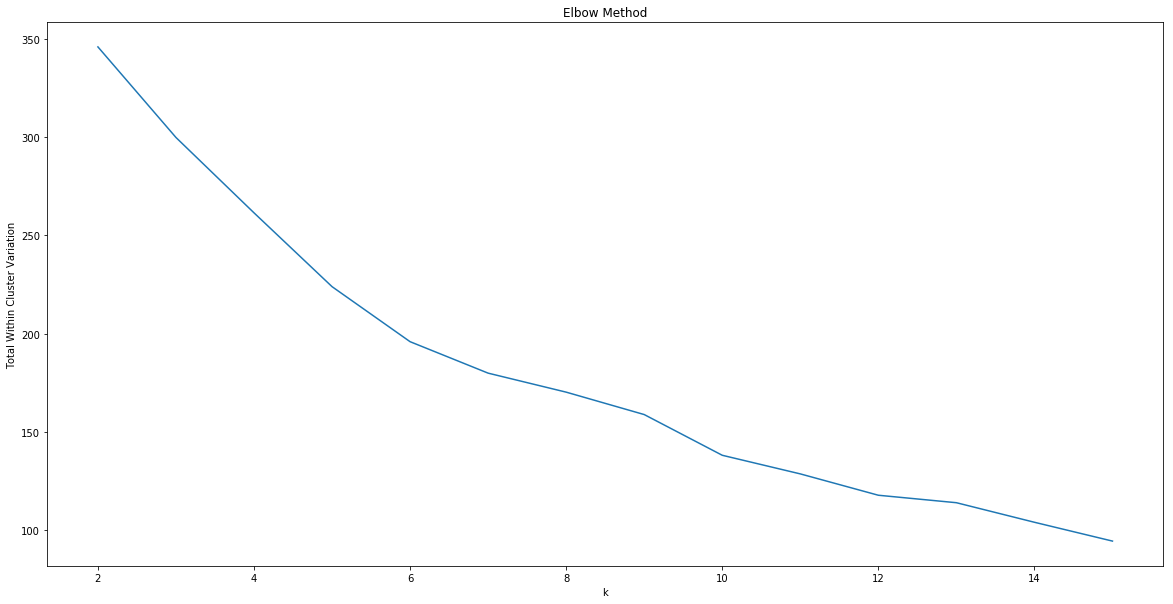

In [139]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Pretty subtle, but maybe 6 or 10?

### Silhouette Method

In [140]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df_2)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [141]:
#Check 
silhouette_score

[0.25683689760896766,
 0.2528569306368524,
 0.12238392140417975,
 0.0462371728775348,
 0.05937244349602166,
 0.052373104045588974,
 0.03575463260617141,
 0.05481490061573689,
 0.003803063067901794,
 0.05333875323993728,
 -0.003939775510465747,
 -0.005302354757305436,
 0.021210619656760635,
 0.011221407803255172]

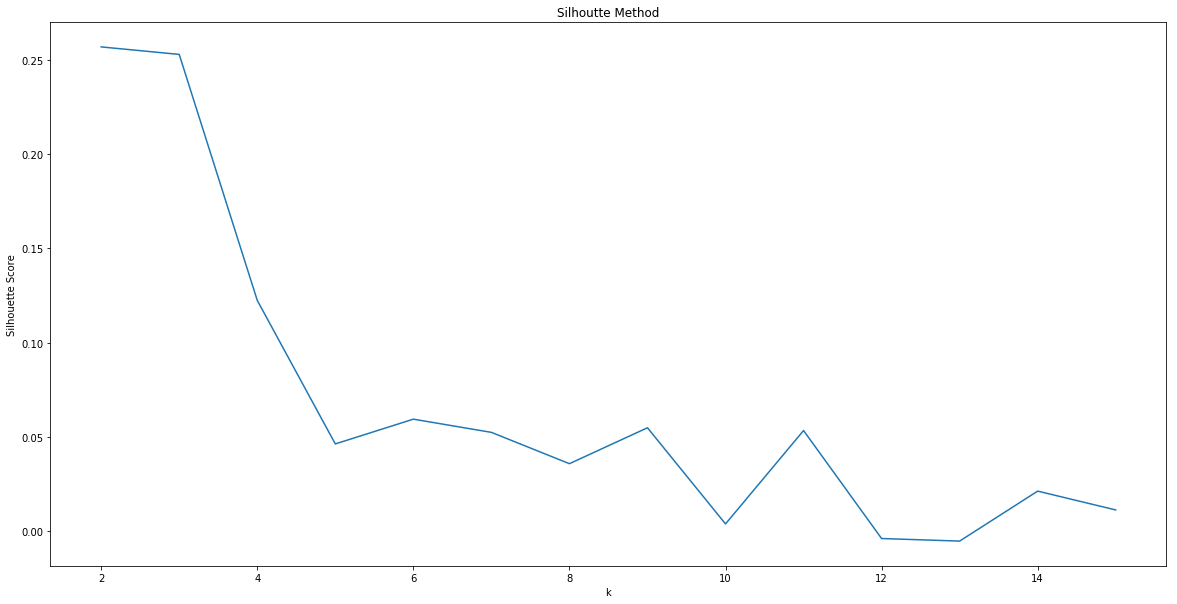

In [142]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


Suggests 2 is the best k!

Between the two, 6 would be more interesting to explore.

### Principal Components Analysis - Round 2

This will help us visualize the clusters.

In [143]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df_2)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(66, 2)

persons_df.dropna(axis=0).shape

In [144]:
pca_df = persons_df.dropna()[['person','domain']].reset_index().join(pca_df)

In [145]:
pca_df.shape

(66, 5)

In [146]:
pca_df.tail()

index      person domain     PCA_1     PCA_2
61     62     delaney   dems  0.495172  0.642853
62     63     moulton   dems  3.319720 -0.181480
63     64    swalwell   dems  1.761400 -1.815353
64     65  williamson   dems  2.821969  2.071879
65     66        yang   dems  1.408044 -0.411109

Now let's look by PCA again, **after adding in new similarity features**.

In [147]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison, with Similiarity Features'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Looks like it really sharpened the distincting between the two PCA groupings; you can (almost) draw a straight line between the two PCA groups, whereas before there was some minor overlap.

### K-Means Clustering - k=6

In [148]:
#### Model with selected k
k_selected = 6

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df_2)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [149]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

In [150]:
# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [151]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Kind of compelling. There is some bleed.

In [152]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

This is more compelling than just looking at positive vs negative; makes sense because the PCAs have reduced the dimensions down.

Let's look at clusters in order.

In [153]:
persons_cluster.sort_values(by=['cluster'], axis=0)

neg       pos  comment_length  sub_num_comments  \
person                                                               
mance         0.095994  0.117767      493.245283        609.440252   
night_king    0.096079  0.121316      371.236842        903.605263   
joffrey       0.109822  0.140544      520.881590        909.345499   
littlefinger  0.109987  0.113178      765.276119        667.201493   
grey worm     0.096666  0.149123      717.217759        805.680761   
varys         0.101486  0.127533      800.279455       1004.412374   
stannis       0.108586  0.120870      653.408506        560.555885   
gendry        0.098096  0.091402      643.932039        598.542718   
davos         0.124050  0.092575      692.760499        529.203178   
tyrion        0.108242  0.118347      803.106100        811.753004   
jon           0.105712  0.123610      797.009912        840.442815   
sansa         0.106343  0.116680      836.954370        752.102963   
doran         0.086200  0.117733      532.200000        453.000000   
delaney       0.100648  0.073381      592.190476        556.676190   
hodor         0.058301  0.060560      917.197970        932.293147   
klobuchar     0.099053  0.058791      570.262032        845.090909   
biden         0.112405  0.086870      550.885796        732.629943   
gillibrand    0.107993  0.062662      727.267606        521.179577   
gabbard       0.107591  0.092146     1330.751905        688.318571   
yang          0.127172  0.059265      641.174575        984.137668   
jaqen         0.081677  0.087890      668.445122        419.310976   
oberyn        0.118462  0.124522      534.238994        479.792453   
margaery      0.142663  0.100301      481.560241        511.891566   
tommen        0.098114  0.119882      614.760714        648.917857   
tormund       0.126600  0.091105      726.226371        569.534422   
catelyn       0.113957  0.111492      698.189189        466.764865   
ned           0.106490  0.117499      680.973132        676.445937   
ygritte       0.131634  0.102654      500.151220        613.790244   
bran          0.095871  0.096407      831.949230        670.082750   
ramsey        0.108425  0.147383      629.881952        827.227015   
...                ...       ...             ...               ...   
robert        0.099547  0.120995      792.268309        626.171105   
melisandre    0.099591  0.121415      825.482972        536.560372   
bronn         0.111327  0.111018      694.823454        550.132569   
gilly         0.110157  0.078380      502.444444        684.712963   
inslee        0.139332  0.049005      606.786925        466.641646   
swalwell      0.133085  0.066930      554.845070        728.112676   
moulton       0.121841  0.063362      419.956522        505.579710   
bennet        0.117696  0.052884      682.333333        386.449275   
o'rourke      0.123223  0.067286      729.096105        707.070258   
messam        0.096429  0.035143      449.785714        546.214286   
bullock       0.135164  0.064812      352.851562        533.695312   
sanders       0.121713  0.078032      617.271328        856.240578   
castro        0.109613  0.079823      598.161585        731.137195   
booker        0.105749  0.063276      611.475483        668.585438   
hickenlooper  0.104155  0.069456      423.922280        539.564767   
buttigieg     0.121666  0.065769      646.673913       1027.962560   
harris        0.121952  0.073905      601.044709        660.970194   
samwell       0.120397  0.086103      591.793651        486.611111   
warren        0.128463  0.066028      579.511811       1126.075730   
euron         0.097175  0.139224      958.506540       1093.149752   
missandei     0.105467  0.144538      891.237405       1195.407177   
cersei        0.104796  0.141244      865.036902        931.988191   
jamie         0.112045  0.135326      822.123420        896.681269   
jorah         0.112005  0.130566      715.514748       1555.557088   
dany          0.101242  0.136

In [154]:
print(time.ctime(int(time.time())))

Mon Jun 17 22:37:09 2019


-----

### More word embedding exploration

In [178]:
positive_tups = model.wv.most_similar(['awesome', 'favorite', 'best', 'love', 'winner'], topn=100)
positive_tups

[('yesss', 0.7313470244407654),
 ('tvseries', 0.7215601205825806),
 ('favourite', 0.7170934677124023),
 ('unsung', 0.7118857502937317),
 ('favourites', 0.7079457640647888),
 ('❤', 0.7044446468353271),
 ('characterbut', 0.7030686140060425),
 ('favs', 0.7014935612678528),
 ('😥', 0.6982450485229492),
 ('😌', 0.6943471431732178),
 ('😔', 0.6943101286888123),
 ('cutest', 0.6916365623474121),
 ('clapback', 0.6903260946273804),
 ('asda', 0.6882692575454712),
 ('ragnar', 0.6861664056777954),
 ('dialouge', 0.6861587166786194),
 ('likeliest', 0.6856223344802856),
 ('e2', 0.6801967024803162),
 ('speechless', 0.6792536973953247),
 ('primarythis', 0.6789090633392334),
 ('weirdest', 0.6788610219955444),
 ('sandorarya', 0.6781923770904541),
 ('themid', 0.674532413482666),
 ('🥰', 0.6738998889923096),
 ('glimmer', 0.6728613376617432),
 ('hardhomme', 0.6715291738510132),
 ('marvellous', 0.6711967587471008),
 ('fav', 0.6702016592025757),
 ('petted', 0.6698603630065918),
 ('lold', 0.6690230369567871),
 ('to

In [179]:
negative_tups = model.wv.most_similar(['worst', 'hate', 'sucks', 'boring', 'loser'], topn=100)

In [180]:
negative_list = []
for i in negative_tups: 
    negative_word = (i[0])
    negative_list.append(negative_word)

positive_list = []
for i in positive_tups: 
    positive_word = (i[0])
    positive_list.append(positive_word)

We could use these to create a ranking of dictionary keys, as a way of looking at sentiment outside of Vader.

## Similarity Dataframe of Characters <a name='clusters3'/>

In [158]:
similarity_df = pca_df[['person', 'domain', 'cluster']]

In [159]:
similarity_df.head()

person domain cluster
0   bran    got       2
1    jon    got       0
2   dany    got       4
3  davos    got       0
4  doran    got       0

We created a 'cleaned up' version of the `persons_dict`, where names are cleaned up for spaces, or if they don't exist in the Word2Vec vocabulary.

In [160]:
for key, value in no_spaces_dict.items():
    helper.add_similarity_score(tgt_word=value, 
                            topn=100000, 
                            w2v_model=model, 
                            tgt_df=similarity_df,
                           term_vocab=terms,
                           person_mat=person_mat.T, 
                               custom_column=key)

bran
Completed for:bran
jon


/Users/tjjj/mia/projects/fsp/got-demo/helper.py:170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Completed for:jon
dany
Completed for:dany
davos
Completed for:davos
doran
Completed for:doran
cersei
Completed for:cersei
tyrion
Completed for:tyrion
sansa
Completed for:sansa
arya
Completed for:arya
stannis
Completed for:stannis
varys
Completed for:varys
jamie
Completed for:jamie
brienne
Completed for:brienne
samwell
Completed for:samwell
jorah
Completed for:jorah
theon
Completed for:theon
hound
Completed for:hound
littlefinger
Completed for:littlefinger
joffrey
Completed for:joffrey
mountain
Completed for:mountain
robb
Completed for:robb
dragons
Completed for:dragons
melisandre
Completed for:melisandre
bronn
Completed for:bronn
gilly
Completed for:gilly
ramsey
Completed for:ramsey
missandei
Completed for:missandei
gendry
Completed for:gendry
grey worm
Completed for:grey worm
ned
Completed for:ned
catelyn
Completed for:catelyn
tormund
Completed for:tormund
robert
Completed for:robert
tommen
Completed for:tommen
viserys
Completed for:viserys
margaery
Completed for:margaery
euron
Comple

In [161]:
similarity_df.head()

person domain cluster  similarity_bran  similarity_jon  similarity_dany  \
0   bran    got       2         0.000000        0.710252         0.582901   
1    jon    got       0         0.710252        0.000000         0.790640   
2   dany    got       4         0.505402        0.685521         0.000000   
3  davos    got       0         0.580700        0.649777         0.570611   
4  doran    got       0         0.352486        0.479331         0.499968   

   similarity_davos  similarity_doran  similarity_cersei  similarity_tyrion  \
0          0.580700          0.352486           0.499271           0.606989   
1          0.649777          0.479330           0.621401           0.746200   
2          0.494745          0.433495           0.612585           0.613213   
3          0.000000          0.539376           0.484866           0.752199   
4          0.539377          0.000000           0.470348           0.598777   

   ...  similarity_bullock  similarity_gravel  similarity_messam  \
0  ...            0.289631           0.261841           0.185400   
1  ...            0.266628           0.256972           0.164594   
2  ...            0.155853           0.187709           0.177151   
3  ...            0.497214           0.461066           0.465350   
4  ...            0.321836           0.242678           0.357790   

   similarity_o'rourke  similarity_bennet  similarity_delaney  \
0             0.257462           0.262065            0.157901   
1             0.283792           0.311176            0.324746   
2             0.224931           0.218769            0.260115   
3             0.381831           0.486709            0.451804   
4             0.237463           0.326454            0.347928   

   similarity_moulton  similarity_swalwell  similarity_williamson  \
0            0.267187             0.226187               0.269045   
1            0.282101             0.294563               0.297135   
2            0.198906             0.253354               0.199080   
3            0.460013             0.448062               0.526515   
4            0.359821             0.348300               0.249845   

   similarity_yang  
0         0.271055  
1         0.220419  
2         0.223366  
3         0.444935  
4         0.132678  

[5 rows x 69 columns]

Create version of dataframe for heatmap, where categorical columns are dropped.

In [162]:
sim_heatmap = similarity_df.copy().drop(['domain', 'cluster'], axis=1)

sim_heatmap = sim_heatmap.set_index('person')
sim_heatmap.head()

similarity_bran  similarity_jon  similarity_dany  similarity_davos  \
person                                                                       
bran           0.000000        0.710252         0.582901          0.580700   
jon            0.710252        0.000000         0.790640          0.649777   
dany           0.505402        0.685521         0.000000          0.494745   
davos          0.580700        0.649777         0.570611          0.000000   
doran          0.352486        0.479331         0.499968          0.539377   

        similarity_doran  similarity_cersei  similarity_tyrion  \
person                                                           
bran            0.352486           0.499271           0.606989   
jon             0.479330           0.621401           0.746200   
dany            0.433495           0.612585           0.613213   
davos           0.539376           0.484866           0.752199   
doran           0.000000           0.470348           0.598777   

        similarity_sansa  similarity_arya  similarity_stannis  ...  \
person                                                         ...   
bran            0.692972         0.698832            0.447058  ...   
jon             0.830104         0.755644            0.586442  ...   
dany            0.639522         0.605624            0.544690  ...   
davos           0.677723         0.652369            0.616411  ...   
doran           0.487315         0.445289            0.671142  ...   

        similarity_bullock  similarity_gravel  similarity_messam  \
person                                                             
bran              0.289631           0.261841           0.185400   
jon               0.266628           0.256972           0.164594   
dany              0.155853           0.187709           0.177151   
davos             0.497214           0.461066           0.465350   
doran             0.321836           0.242678           0.357790   

        similarity_o'rourke  similarity_bennet  similarity_delaney  \
person                                                               
bran               0.257462           0.262065            0.157901   
jon                0.283792           0.311176            0.324746   
dany               0.224931           0.218769            0.260115   
davos              0.381831           0.486709            0.451804   
doran              0.237463           0.326454            0.347928   

        similarity_moulton  similarity_swalwell  similarity_williamson  \
person                                                                   
bran              0.267187             0.226187               0.269045   
jon               0.282101             0.294563               0.297135   
dany              0.198906             0.253354               0.199080   
davos             0.460013             0.448062               0.526515   
doran             0.359821             0.348300               0.249845   

        similarity_yang  
person                   
bran           0.271055  
jon            0.220419  
dany           0.223366  
davos          0.444935  
doran          0.132678  

[5 rows x 66 columns]

Create heatmap.

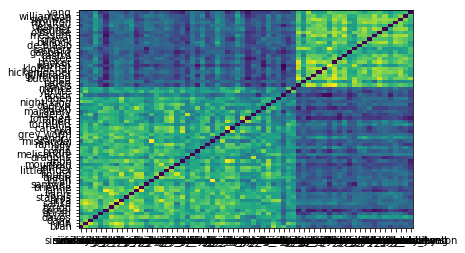

In [163]:
plt.pcolor(sim_heatmap)
plt.yticks(np.arange(0.5, len(sim_heatmap.index), 1), sim_heatmap.index)
plt.xticks(np.arange(0.5, len(sim_heatmap.columns), 1), sim_heatmap.columns)
plt.show()
#a very crowded heatmap

We only care about comparisons between GoT and Demo nominees so remove all other columns/rows.

In [164]:
nsdf = similarity_df.set_index('person')
nsdf = nsdf.iloc[:43, 45:] 

nsdf.head()

similarity_harris  similarity_biden  similarity_buttigieg  \
person                                                              
bran             0.212223          0.368211              0.287490   
jon              0.375637          0.383648              0.336681   
dany             0.299582          0.244535              0.201221   
davos            0.351231          0.258939              0.375836   
doran            0.153445          0.122006              0.160758   

        similarity_gillibrand  similarity_hickenlooper  similarity_klobuchar  \
person                                                                         
bran                 0.175749                 0.279644              0.187931   
jon                  0.267796                 0.290812              0.318812   
dany                 0.281779                 0.204404              0.233460   
davos                0.353166                 0.458372              0.422973   
doran                0.324013                 0.312194              0.315700   

        similarity_warren  similarity_booker  similarity_inslee  \
person                                                            
bran             0.270606           0.267743           0.278574   
jon              0.358014           0.346803           0.251012   
dany             0.351472           0.293930           0.175163   
davos            0.275288           0.448460           0.472948   
doran            0.108541           0.284014           0.195140   

        similarity_castro  ...  similarity_bullock  similarity_gravel  \
person                     ...                                          
bran             0.202860  ...            0.289631           0.261841   
jon              0.271136  ...            0.266628           0.256972   
dany             0.200443  ...            0.155853           0.187709   
davos            0.409233  ...            0.497214           0.461066   
doran            0.313793  ...            0.321836           0.242678   

        similarity_messam  similarity_o'rourke  similarity_bennet  \
person                                                              
bran             0.185400             0.257462           0.262065   
jon              0.164594             0.283792           0.311176   
dany             0.177151             0.224931           0.218769   
davos            0.465350             0.381831           0.486709   
doran            0.357790             0.237463           0.326454   

        similarity_delaney  similarity_moulton  similarity_swalwell  \
person                                                                
bran              0.157901            0.267187             0.226187   
jon               0.324746            0.282101             0.294563   
dany              0.260115            0.198906             0.253354   
davos             0.451804            0.460013             0.448062   
doran             0.347928            0.359821             0.348300   

        similarity_williamson  similarity_yang  
person                                          
bran                 0.269045         0.271055  
jon                  0.297135         0.220419  
dany                 0.199080         0.223366  
davos                0.526515         0.444935  
doran                0.249845         0.132678  

[5 rows x 23 columns]

To simplify our analysis, we decide to focus only on the top 8 nominees, by polling.
https://fivethirtyeight.com/features/the-dnc-tried-to-avoid-a-lopsided-debate-it-got-one-anyway/

- Biden
- Sanders
- Warren
- Buttigieg 
- Harris
- O’Rourke
- Booker
- Klobuchar

In [165]:
dem_col_keep = ['similarity_biden', 'similarity_sanders',
                'similarity_warren', 'similarity_buttigieg',
                'similarity_harris', "similarity_o'rourke",
                'similarity_klobuchar', 'similarity_booker']
nsdf_f = nsdf[dem_col_keep]

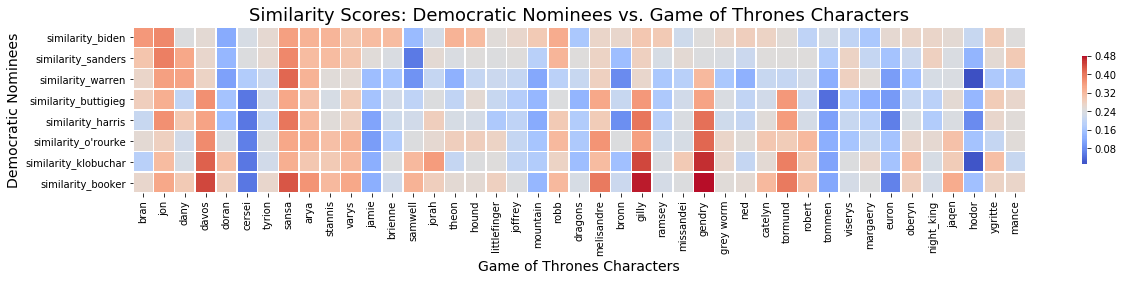

In [166]:
# plot the heatmap

import matplotlib.pyplot as plt
#cmap = sns.diverging_palette(220, 110,as_cmap=True)
cmap = sns.color_palette("RdBu_r", 100)
cmap = sns.color_palette("coolwarm", 100)

fig, ax = plt.subplots(figsize=(20,10)) 

sns.heatmap(nsdf_f.T,
             cmap=cmap,
#             vmax=1,
#             center=0,
            square=True, 
            linewidth=.5, cbar_kws={'shrink': .20})

ax.set_title('Similarity Scores: Democratic Nominees vs. Game of Thrones Characters', fontsize=18)
ax.set_xlabel('Game of Thrones Characters', fontsize = 14)
ax.set_ylabel('Democratic Nominees', fontsize = 14)
ax.ticklabel_format()

plt.savefig('sim_heatmap.png')


This is a bit overwhelming visually, what if we paired down the GoT characters, using our own 'expert' fan opinion?

In [167]:
got_col_keep = ['bran','jon','dany','samwell','tyrion','davos','sansa','arya']
nsdf_ff = nsdf_f.loc[got_col_keep,]

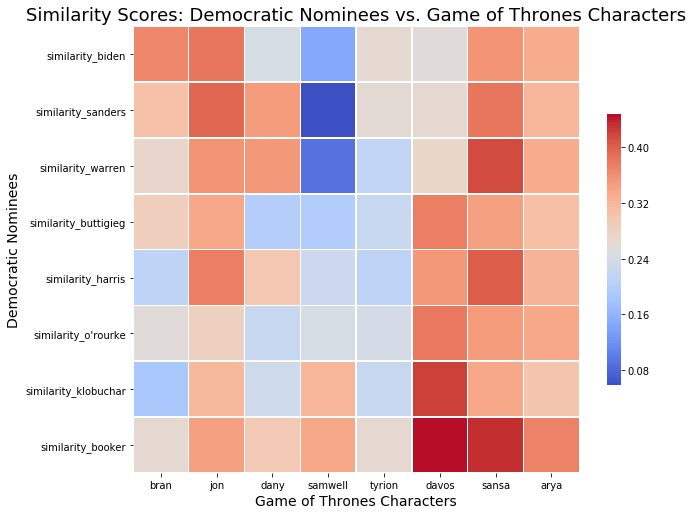

In [168]:
# plot the heatmap

import matplotlib.pyplot as plt
#cmap = sns.diverging_palette(220, 110,as_cmap=True)
cmap = sns.color_palette("RdBu_r", 100)
cmap = sns.color_palette("coolwarm", 100)

fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(nsdf_ff.T,
             cmap=cmap,
#             vmax=1,
#             center=0,
            square=True, 
            linewidth=.5, cbar_kws={'shrink': .50})

ax.set_title('Similarity Scores: Democratic Nominees vs. Game of Thrones Characters', fontsize=18)
ax.set_xlabel('Game of Thrones Characters', fontsize = 14)
ax.set_ylabel('Democratic Nominees', fontsize = 14)
ax.ticklabel_format()

plt.savefig('sim_heatmap_final.png')


In [169]:
nsdf_ff.T

person                    bran       jon      dany   samwell    tyrion  \
similarity_biden      0.368211  0.383648  0.244535  0.143788  0.264953   
similarity_sanders    0.304691  0.394691  0.348614  0.057809  0.264180   
similarity_warren     0.270606  0.358014  0.351472  0.090338  0.215066   
similarity_buttigieg  0.287490  0.336681  0.201221  0.197880  0.223464   
similarity_harris     0.212223  0.375637  0.299582  0.227097  0.212129   
similarity_o'rourke   0.257462  0.283792  0.224931  0.243539  0.238639   
similarity_klobuchar  0.187931  0.318812  0.233460  0.322600  0.224866   
similarity_booker     0.267743  0.346803  0.293930  0.335618  0.266628   

person                   davos     sansa      arya  
similarity_biden      0.258939  0.355401  0.334166  
similarity_sanders    0.266762  0.384957  0.321634  
similarity_warren     0.275288  0.416851  0.334729  
similarity_buttigieg  0.375836  0.345742  0.309239  
similarity_harris     0.351231  0.404950  0.325541  
similarity_o'rourke   0.381831  0.348460  0.336376  
similarity_klobuchar  0.422973  0.338344  0.300027  
similarity_booker     0.448460  0.434200  0.373575

We hoped to interpret the above to get obvious mutual pairs, but it's painting us into weird corners. What if we go back to the entire list of GoT characters and choose from a subset of top 5-10 choices from each. We would still do it 'draft-style' in that if we assign a character to a nominee, we can't use them again. We assess by highest polling numbers to least.

In [170]:
nsdf_f[["similarity_biden"]].sort_values(by=["similarity_biden"], axis=0, ascending=False).head(10)

similarity_biden
person                   
jon              0.383648
bran             0.368211
sansa            0.355401
robb             0.344392
arya             0.334166
theon            0.332812
stannis          0.330943
brienne          0.321483
hound            0.318771
jamie            0.318051

In [171]:
nsdf_f[["similarity_sanders"]].sort_values(by=["similarity_sanders"], axis=0, ascending=False).head(10)

similarity_sanders
person                     
jon                0.394691
sansa              0.384957
dany               0.348614
robb               0.330775
arya               0.321634
stannis            0.317806
varys              0.306242
bran               0.304691
mance              0.293797
gilly              0.283403

In [172]:
nsdf_f[["similarity_warren"]].sort_values(by=["similarity_warren"], axis=0, ascending=False).head(10)

similarity_warren
person                       
sansa                0.416851
jon                  0.358014
dany                 0.351472
arya                 0.334729
gendry               0.325272
melisandre           0.281691
viserys              0.281408
davos                0.275288
bran                 0.270606
gilly                0.265731

In [173]:
nsdf_f[["similarity_buttigieg"]].sort_values(by=["similarity_buttigieg"], axis=0, ascending=False).head(10)

similarity_buttigieg
person                          
davos                   0.375836
tormund                 0.366360
gilly                   0.364722
gendry                  0.350177
melisandre              0.347262
sansa                   0.345742
jon                     0.336681
arya                    0.309239
ygritte                 0.291021
varys                   0.288737

In [174]:
nsdf_f[["similarity_harris"]].sort_values(by=["similarity_harris"], axis=0, ascending=False).head(10)

similarity_harris
person                       
gendry               0.408488
sansa                0.404950
gilly                0.403441
jon                  0.375637
tormund              0.359931
davos                0.351231
arya                 0.325541
dany                 0.299582
robb                 0.296986
melisandre           0.292358

In [175]:
nsdf_f[["similarity_o'rourke"]].sort_values(by=["similarity_o'rourke"], axis=0, ascending=False).head(10)

similarity_o'rourke
person                         
gendry                 0.417221
davos                  0.381831
melisandre             0.369033
gilly                  0.357191
sansa                  0.348460
arya                   0.336376
varys                  0.331326
robert                 0.323160
robb                   0.322847
stannis                0.315371

In [176]:
nsdf_f[["similarity_booker"]].sort_values(by=["similarity_booker"], axis=0, ascending=False).head(10)

similarity_booker
person                       
gendry               0.482168
gilly                0.473512
davos                0.448460
sansa                0.434200
tormund              0.398828
melisandre           0.398002
arya                 0.373575
jon                  0.346803
varys                0.346716
jaqen                0.345222

In [177]:
nsdf_f[["similarity_klobuchar"]].sort_values(by=["similarity_klobuchar"], axis=0, ascending=False).head(10)

similarity_klobuchar
person                          
gendry                  0.465026
gilly                   0.444672
davos                   0.422973
tormund                 0.393186
jorah                   0.363987
sansa                   0.338344
varys                   0.323152
samwell                 0.322600
melisandre              0.321109
jon                     0.318812